In [1]:
%load_ext autoreload
%autoreload 2



In [2]:
# Get the SHAP values for each MIL model. 
## Question: does SHAP considers cross patient heterogeneity? #####
import os
import torch
import shap
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



os.chdir("/Users/kristintsui/HA_MIL_model/NIPS2025_Supplementary/code")





/Users/kristintsui/mamba/envs/scgpt_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from src.Autoencoder import Autoencoder
from src.MIL import AttentionMIL

# Run patient level SHAP

In [6]:
from patient_level_SHAP import run_patient_level_shap
# === Load shared Autoencoder ===
autoencoder_path = "/Users/kristintsui/HA_MIL_model/tcellMIL/run_Sample_source_added_tcellMIL/autoencoder/best_autoencoder.pth"
# autoencoder = Autoencoder(input_dim=154, latent_dim=64)
# autoencoder.load_state_dict(torch.load(autoencoder_path, map_location="cpu"))
# autoencoder.eval()

# === Load and preprocess full dataset ===
data_path = "/Users/kristintsui/HA_MIL_model/tcellMIL/data/cell_atlas_axicel_IP_scenic_tf_matrix_added_v2.h5ad"
# adata = sc.read_h5ad("/Users/kristintsui/HA_MIL_model/tcellMIL/data/cell_atlas_axicel_IP_scenic_tf_matrix_added_v2.h5ad")
# adata = adata[~adata.obs['Response_3m'].isna()].copy()
# adata.X = (adata.X - 0.5) * 2  # match autoencoder preprocessing
# tf_names = adata.var_names.tolist()
# source_list = list(adata.obs["Sample_source"].unique())

#check TF data is between -1 and +1
# Get index of the TF
# tf_idx = adata.var_names.get_loc("JUND")
# print(adata.X[:,tf_idx])


# === Path to MIL models directory ===
mil_root_dir = "/Users/kristintsui/HA_MIL_model/tcellMIL/run_Sample_source_added_tcellMIL/mil"
# patient_dirs = [d for d in os.listdir(mil_root_dir) if os.path.isdir(os.path.join(mil_root_dir, d))]

run_patient_level_shap(autoencoder_path, mil_root_dir, data_path, output_dir="shap_results")







Loading data...
Loading autoencoder...
Creating background dataset...
Processing patient ac19...


/Users/kristintsui/HA_MIL_model/NIPS2025_Supplementary/code/patient_level_SHAP.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(au

Running SHAP for patient ac19...


ValueError: Per-column arrays must each be 1-dimensional

In [ ]:
# === Loop through each MIL model folder ===
# for patient_folder in patient_dirs:
#     patient_id = patient_folder.replace("patient_", "")
#     model_path = os.path.join(mil_root_dir, patient_folder, "best_model.pth")

#     # --- Load MIL model ---
#     mil_model = AttentionMIL(input_dim=64, num_classes=2, hidden_dim=128, sample_source_dim=4)
#     mil_model.load_state_dict(torch.load(model_path, map_location="cpu"))
#     mil_model.eval()

#     # --- Prepare test patient data ---
#     adata_test = adata[adata.obs['patient_id'] == patient_id]
#     if adata_test.shape[0] == 0:
#         print(f"Skipping {patient_id} — no test data found.")
#         continue

#     X_test = adata_test.X.toarray() if not isinstance(adata_test.X, np.ndarray) else adata_test.X
#     X_test_tensor = torch.FloatTensor(X_test)

#     sample_source = adata_test.obs["Sample_source"].unique()[0]
#     source_index = source_list.index(sample_source)
#     sample_onehot = torch.FloatTensor(np.eye(len(source_list))[source_index]).unsqueeze(0)

#     # --- Background data from other patients ---
#     # adata_bg = adata[adata.obs['patient_id'] != patient_id][:5000]
#     adata_bg = adata[adata.obs['patient_id'] != patient_id].copy()
#     adata_bg = adata_bg[np.random.choice(adata_bg.shape[0], size=5000, replace=False)]
#     X_bg = adata_bg.X.toarray() if not isinstance(adata_bg.X, np.ndarray) else adata_bg.X
#     X_bg_tensor = torch.FloatTensor(X_bg)

#     # --- Wrap Autoencoder + MIL ---
#     class AE_MIL_Wrapper(torch.nn.Module):
#         def __init__(self, ae, mil, sample_source_tensor):
#             super().__init__()
#             self.ae = ae
#             self.mil = mil
#             self.sample_source_tensor = sample_source_tensor

#         def forward(self, x):
#             z = self.ae.encode(x)
#             return self.mil([z], self.sample_source_tensor)

#     combined_model = AE_MIL_Wrapper(autoencoder, mil_model, sample_onehot)

#     # --- Run SHAP ---
#     explainer = shap.GradientExplainer(combined_model, X_bg_tensor)
#     shap_values = explainer.shap_values(X_test_tensor)

#     # --- Save SHAP Class 1 (positive) ---
#     shap_vals_class1 = shap_values[:, :, 1]
#     mean_shap_vals_class1 = np.mean(np.abs(shap_vals_class1), axis=0)
#     df_class1 = pd.DataFrame({'TF': tf_names, 'mean_abs_SHAP': mean_shap_vals_class1})
#     df_class1 = df_class1.sort_values(by='mean_abs_SHAP', ascending=False)
#     df_class1.to_csv(f"{mil_root_dir}/{patient_folder}_shap_TF_importance_class1.csv", index=False)

#     # --- Save SHAP Class 0 (negative) ---
#     shap_vals_class0 = shap_values[:, :, 0]
#     mean_shap_vals_class0 = np.mean(np.abs(shap_vals_class0), axis=0)
#     df_class0 = pd.DataFrame({'TF': tf_names, 'mean_abs_SHAP': mean_shap_vals_class0})
#     df_class0 = df_class0.sort_values(by='mean_abs_SHAP', ascending=False)
#     df_class0.to_csv(f"{mil_root_dir}/{patient_folder}_shap_TF_importance_class0.csv", index=False)

#     # --- Directional SHAP Difference ---
#     mean_signed_class1 = np.mean(shap_vals_class1, axis=0)
#     mean_signed_class0 = np.mean(shap_vals_class0, axis=0)
#     shap_diff = mean_signed_class1 - mean_signed_class0

#     df_diff = pd.DataFrame({'TF': tf_names, 'SHAP_diff': shap_diff})
#     df_diff.to_csv(f"{mil_root_dir}/{patient_folder}_top_directional_TFs.csv", index=False)

#     # --- Plot top directional TFs ---
#     top_n = 29
#     df_top = df_diff.reindex(df_diff.SHAP_diff.abs().sort_values(ascending=False).index).head(top_n)
#     df_top = df_top[::-1]
#     colors = ['green' if val > 0 else 'red' for val in df_top['SHAP_diff']]

#     plt.figure(figsize=(10, 7))
#     plt.barh(df_top['TF'], df_top['SHAP_diff'], color=colors)
#     plt.axvline(0, color='black', linestyle='--')
#     plt.title(f"Top {top_n} TFs Driving Prediction – Patient {patient_id}")
#     plt.xlabel("Mean SHAP(Class 1) − Mean SHAP(Class 0)")
#     plt.ylabel("TF")
#     plt.tight_layout()
#     plt.savefig(f"{mil_root_dir}/{patient_folder}_shap_directional_plot.png")
#     plt.close()

#     print(f"✅ Processed SHAP for patient {patient_id}")

In [9]:
adata.X.min()

np.float64(-1.0)

In [10]:
################ v1

# === Load shared Autoencoder ===
autoencoder_path = "/Users/kristintsui/HA_MIL_model/tcellMIL/run_Sample_source_added_tcellMIL/autoencoder/best_autoencoder.pth"
autoencoder = Autoencoder(input_dim=154, latent_dim=64)
autoencoder.load_state_dict(torch.load(autoencoder_path, map_location="cpu"))
autoencoder.eval()

# === Load and preprocess full dataset ===
adata = sc.read_h5ad("data/cell_atlas_axicel_IP_scenic_tf_matrix_added_v2.h5ad")
adata = adata[~adata.obs['Response_3m'].isna()].copy()
adata.X = (adata.X - 0.5) * 2  # match autoencoder preprocessing
tf_names = adata.var_names.tolist()
source_list = list(adata.obs["Sample_source"].unique())

#check TF data is between -1 and +1
# Get index of the TF
tf_idx = adata.var_names.get_loc("JUND")
print(adata.X[:,tf_idx])


# === Path to MIL models directory ===
mil_root_dir = "/Users/kristintsui/HA_MIL_model/tcellMIL/run_Sample_source_added_tcellMIL/mil"
patient_dirs = [d for d in os.listdir(mil_root_dir) if os.path.isdir(os.path.join(mil_root_dir, d))]

# === Loop through each MIL model folder ===
for patient_folder in patient_dirs:
    patient_id = patient_folder.replace("patient_", "")
    model_path = os.path.join(mil_root_dir, patient_folder, "best_model.pth")

    # --- Load MIL model ---
    mil_model = AttentionMIL(input_dim=64, num_classes=2, hidden_dim=128, sample_source_dim=4)
    mil_model.load_state_dict(torch.load(model_path, map_location="cpu"))
    mil_model.eval()

    # --- Prepare test patient data ---
    adata_test = adata[adata.obs['patient_id'] == patient_id]
    if adata_test.shape[0] == 0:
        print(f"Skipping {patient_id} — no test data found.")
        continue

    X_test = adata_test.X.toarray() if not isinstance(adata_test.X, np.ndarray) else adata_test.X
    X_test_tensor = torch.FloatTensor(X_test)

    sample_source = adata_test.obs["Sample_source"].unique()[0]
    source_index = source_list.index(sample_source)
    sample_onehot = torch.FloatTensor(np.eye(len(source_list))[source_index]).unsqueeze(0)

    # --- Background data from other patients ---
    # adata_bg = adata[adata.obs['patient_id'] != patient_id][:5000]
    adata_bg = adata[adata.obs['patient_id'] != patient_id].copy()
    adata_bg = adata_bg[np.random.choice(adata_bg.shape[0], size=5000, replace=False)]
    X_bg = adata_bg.X.toarray() if not isinstance(adata_bg.X, np.ndarray) else adata_bg.X
    X_bg_tensor = torch.FloatTensor(X_bg)

    # --- Wrap Autoencoder + MIL ---
    class AE_MIL_Wrapper(torch.nn.Module):
        def __init__(self, ae, mil, sample_source_tensor):
            super().__init__()
            self.ae = ae
            self.mil = mil
            self.sample_source_tensor = sample_source_tensor

        def forward(self, x):
            z = self.ae.encode(x)
            return self.mil([z], self.sample_source_tensor)

    combined_model = AE_MIL_Wrapper(autoencoder, mil_model, sample_onehot)

    # --- Run SHAP ---
    explainer = shap.GradientExplainer(combined_model, X_bg_tensor)
    shap_values = explainer.shap_values(X_test_tensor)

    # --- Save SHAP Class 1 (positive) ---
    shap_vals_class1 = shap_values[:, :, 1]
    mean_shap_vals_class1 = np.mean(np.abs(shap_vals_class1), axis=0)
    df_class1 = pd.DataFrame({'TF': tf_names, 'mean_abs_SHAP': mean_shap_vals_class1})
    df_class1 = df_class1.sort_values(by='mean_abs_SHAP', ascending=False)
    df_class1.to_csv(f"{mil_root_dir}/{patient_folder}_shap_TF_importance_class1.csv", index=False)

    # --- Save SHAP Class 0 (negative) ---
    shap_vals_class0 = shap_values[:, :, 0]
    mean_shap_vals_class0 = np.mean(np.abs(shap_vals_class0), axis=0)
    df_class0 = pd.DataFrame({'TF': tf_names, 'mean_abs_SHAP': mean_shap_vals_class0})
    df_class0 = df_class0.sort_values(by='mean_abs_SHAP', ascending=False)
    df_class0.to_csv(f"{mil_root_dir}/{patient_folder}_shap_TF_importance_class0.csv", index=False)

    # --- Directional SHAP Difference ---
    mean_signed_class1 = np.mean(shap_vals_class1, axis=0)
    mean_signed_class0 = np.mean(shap_vals_class0, axis=0)
    shap_diff = mean_signed_class1 - mean_signed_class0

    df_diff = pd.DataFrame({'TF': tf_names, 'SHAP_diff': shap_diff})
    df_diff.to_csv(f"{mil_root_dir}/{patient_folder}_top_directional_TFs.csv", index=False)

    # --- Plot top directional TFs ---
    top_n = 29
    df_top = df_diff.reindex(df_diff.SHAP_diff.abs().sort_values(ascending=False).index).head(top_n)
    df_top = df_top[::-1]
    colors = ['green' if val > 0 else 'red' for val in df_top['SHAP_diff']]

    plt.figure(figsize=(10, 7))
    plt.barh(df_top['TF'], df_top['SHAP_diff'], color=colors)
    plt.axvline(0, color='black', linestyle='--')
    plt.title(f"Top {top_n} TFs Driving Prediction – Patient {patient_id}")
    plt.xlabel("Mean SHAP(Class 1) − Mean SHAP(Class 0)")
    plt.ylabel("TF")
    plt.tight_layout()
    plt.savefig(f"{mil_root_dir}/{patient_folder}_shap_directional_plot.png")
    plt.close()

    print(f"✅ Processed SHAP for patient {patient_id}")







/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_63374/974894659.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(autoenc

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'data/cell_atlas_axicel_IP_scenic_tf_matrix_added_v2.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [13]:
adata.var_names.tolist()

Index(['ATF1', 'ATF2', 'ATF3', 'ATF5', 'BACH2', 'BATF', 'BCL11A', 'BHLHE41',
       'CEBPA', 'CEBPB',
       ...
       'ZBTB17', 'ZBTB20', 'ZBTB25', 'ZNF225', 'ZNF35', 'ZNF354B', 'ZNF354C',
       'ZNF367', 'ZNF407', 'ZNF580'],
      dtype='object', name='features', length=154)

In [14]:
# save adata.obs to csv
adata.obs.to_csv("data/cell_atlas_axicel_IP_scenic_tf_matrix_added_v2_obs.csv", index=False)


In [ ]:
df = pd.DataFrame({
    "TF": adata.var_names.tolist(),                         # Transcription factor names
    "shap_diff": [...],                 # Mean SHAP difference (OR - NR)
    "attention_corr": [...],           # Kendall Tau per TF
    "p_adj": [...],                     # Adjusted p-values
})
df["log_p"] = -np.log10(df["p_adj"])
df["highlight"] = df["TF"].isin([...])  # TFs you want to label


In [6]:
import glob

meta = adata.obs[["patient_id", "Response_3m"]].copy()
meta["response_label"] = meta["Response_3m"].map({"OR": 1, "NR": 0})
meta = meta.dropna()

# Load SHAP files
shap_files = glob.glob("/Users/kristintsui/HA_MIL_model/tcellMIL/run_Sample_source_added_tcellMIL/mil/*.csv")
shap_all = []

for f in shap_files:
    df = pd.read_csv(f)
    pid = f.split("/")[-1].split("_")[1]  # adjust if naming is different
    df["patient_id"] = pid
    shap_all.append(df)

shap_df = pd.concat(shap_all)
shap_df = shap_df.merge(meta.reset_index(), on="patient_id")

grouped = shap_df.groupby(["TF", "response_label"])["mean_abs_SHAP"].mean().unstack()
grouped["shap_diff"] = grouped[1] - grouped[0]

# Optional: p-values using Mann–Whitney U
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

def compute_p(tf):
    or_vals = shap_df[(shap_df["TF"] == tf) & (shap_df["response_label"] == 1)]["mean_abs_SHAP"]
    nr_vals = shap_df[(shap_df["TF"] == tf) & (shap_df["response_label"] == 0)]["mean_abs_SHAP"]
    if len(or_vals) < 3 or len(nr_vals) < 3:
        return 1.0
    return mannwhitneyu(or_vals, nr_vals, alternative="two-sided").pvalue

grouped["pval"] = grouped.index.to_series().apply(compute_p)
grouped["p_adj"] = multipletests(grouped["pval"], method="fdr_bh")[1]

/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_37260/1000441691.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = shap_df.groupby(["TF", "response_label"])["mean_abs_SHAP"].mean().unstack()


KeyboardInterrupt: 

In [17]:
grouped = shap_df.groupby(["TF", "response_label"])["mean_abs_SHAP"].mean().unstack()
grouped["shap_diff"] = grouped[1] - grouped[0]

# Optional: p-values using Mann–Whitney U
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

def compute_p(tf):
    or_vals = shap_df[(shap_df["TF"] == tf) & (shap_df["response_label"] == 1)]["mean_abs_SHAP"]
    nr_vals = shap_df[(shap_df["TF"] == tf) & (shap_df["response_label"] == 0)]["mean_abs_SHAP"]
    if len(or_vals) < 3 or len(nr_vals) < 3:
        return 1.0
    return mannwhitneyu(or_vals, nr_vals, alternative="two-sided").pvalue

grouped["pval"] = grouped.index.to_series().apply(compute_p)
grouped["p_adj"] = multipletests(grouped["pval"], method="fdr_bh")[1]


/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_3964/346408967.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = shap_df.groupby(["TF", "response_label"])["mean_abs_SHAP"].mean().unstack()


In [10]:
import pickle
with open("/Users/kristintsui/HA_MIL_model/tcellMIL/data/MIL_downstream_72_mil_results_attention_weights.pkl", "rb") as f:
    MIL_results = pickle.load(f)
attention_df = pd.DataFrame(MIL_results["attention_weights"])#, index=adata.obs_names, columns=adata.var_names)



In [21]:
attention_df.head()

,Pt237,Pt245,Pt253,Pt263,Pt276,Pt282,Pt375,01,02,03,...,ac32,ac33,ac34,ac37,ac38,ac39,CAR122,CAR128,CAR139,CAR142
0,"[[0.000114809525], [0.00011379815], [0.0001156...","[[1.7097098e-05], [1.6920776e-05], [5.485083e-...","[[4.015153e-05], [3.8142316e-05], [3.8855822e-...","[[6.4307256e-05], [6.423664e-05], [0.000276917...","[[0.00083870365], [0.00083776994], [0.00081538...","[[0.023169179], [5.885567e-05], [0.0011796976]...","[[5.44528e-05], [0.00095631595], [5.653581e-05...","[[2.6663254e-05], [0.0042768884], [0.003087217...","[[0.006305137], [0.0004956424], [0.0003192061]...","[[0.00019846637], [0.008521955], [1.7786595e-0...",...,"[[4.284611e-06], [0.004978546], [0.00013811275...","[[0.0017213185], [0.0021139313], [0.0036276053...","[[0.008310398], [2.5859634e-05], [2.0733161e-0...","[[1.239474e-05], [0.0042477343], [0.0033215499...","[[2.3497068e-05], [2.4064058e-05], [2.2749782e...","[[0.00085856434], [1.9583114e-05], [2.96237e-0...","[[0.098943695], [0.00020102874], [0.0002014807...","[[0.00011882866], [0.00011376826], [0.00011403...","[[0.00012731767], [0.00021554132], [9.515232e-...","[[3.5889287e-05], [3.6757516e-05], [3.657757e-..."


In [22]:
all_attns = np.concatenate([np.hstack(attention_df[p]).flatten() for p in attention_df.keys()])

In [6]:
import pandas as pd
import scipy
from statsmodels.stats.multitest import multipletests

import glob

meta = adata.obs[["patient_id", "Response_3m"]].copy()
meta["response_label"] = meta["Response_3m"].map({"OR": 1, "NR": 0})
meta = meta.dropna()

# Load SHAP files
shap_files = glob.glob("/Users/kristintsui/HA_MIL_model/tcellMIL/run_Sample_source_added_tcellMIL/mil/*_v2.csv")
shap_all = []

for f in shap_files:
    df = pd.read_csv(f)
    pid = f.split("/")[-1].split("_")[1]  # adjust if naming is different
    df["patient_id"] = pid
    shap_all.append(df)

shap_df = pd.concat(shap_all)
shap_df = shap_df.merge(meta.reset_index(), on="patient_id")

grouped = shap_df.groupby(["TF", "response_label"])["mean_abs_SHAP"].mean().unstack()
grouped["shap_diff"] = grouped[1] - grouped[0]

# Optional: p-values using Mann–Whitney U
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

def compute_p(tf):
    or_vals = shap_df[(shap_df["TF"] == tf) & (shap_df["response_label"] == 1)]["mean_abs_SHAP"]
    nr_vals = shap_df[(shap_df["TF"] == tf) & (shap_df["response_label"] == 0)]["mean_abs_SHAP"]
    if len(or_vals) < 3 or len(nr_vals) < 3:
        return 1.0
    return mannwhitneyu(or_vals, nr_vals, alternative="two-sided").pvalue

grouped["pval"] = grouped.index.to_series().apply(compute_p)
grouped["p_adj"] = multipletests(grouped["pval"], method="fdr_bh")[1]

def find_correlation_between_attn_and_gene(attn_weights, adata):
    correlations = []
    p_values = []
    correlations_kendall = []
    p_values_kendall = []

    for i in range(adata.X.shape[1]):
        gene_expr = np.array(adata.X[:, i]).flatten()
        corr, p_val = scipy.stats.spearmanr(all_attns, gene_expr)
        # do kendall tau as well
        corr_kendall, p_val_kendall = scipy.stats.kendalltau(all_attns, gene_expr)
        correlations.append(corr)
        p_values.append(p_val)
        correlations_kendall.append(corr_kendall)
        p_values_kendall.append(p_val_kendall)

    # multiple testing 
    _, p_values_adj = multipletests(p_values, method='fdr_bh')[:2]
    _, p_values_kendall_adj = multipletests(p_values_kendall, method='fdr_bh')[:2]

    results = pd.DataFrame({
        'correlation': correlations,
        'p_value': p_values,
        'p_value_adjusted': p_values_adj,
        'correlation_kendall': correlations_kendall,
        'p_value_kendall': p_values_kendall,
        'p_value_kendall_adjusted': p_values_kendall_adj
    })

    return results
results = find_correlation_between_attn_and_gene(attention_df, adata)


NameError: name 'adata' is not defined

In [26]:
# Add gene names from adata.var_names to the results DataFrame
results['gene_name'] = adata.var_names

In [38]:
grouped.head()

response_label,0,1,shap_diff,pval,p_adj
TF,,,,,
ATF1,0.000284,0.000291,0.000007,NaN,NaN
ATF2,0.000329,0.000324,-0.000005,NaN,NaN
ATF3,0.000351,0.000343,-0.000007,NaN,NaN
ATF5,0.001413,0.001155,-0.000258,NaN,NaN
BACH2,0.000303,0.000353,0.000050,NaN,NaN


In [27]:
results.head()

,correlation,p_value,p_value_adjusted,correlation_kendall,p_value_kendall,p_value_kendall_adjusted,gene_name
0,0.057804,5.528028e-28,1.064145e-27,0.038858,2.237594e-28,4.361892e-28,ATF1
1,-0.013131,1.279957e-02,1.552074e-02,-0.008997,1.542638e-02,1.835041e-02,ATF2
2,-0.112172,5.851378e-101,2.435438e-100,-0.073903,5.009592e-98,2.085073e-97,ATF3
3,-0.012884,1.459027e-02,1.741785e-02,-0.009192,1.366910e-02,1.644564e-02,ATF5
4,-0.114139,1.736831e-104,8.105212e-104,-0.084364,3.440492e-103,1.655737e-102,BACH2


In [45]:
attention_corr_df = pd.DataFrame(results["correlation"], columns=["gene_name", "correlation"])

In [47]:
attention_corr_df["TF"] = adata.var_names
attention_corr_df.head()
# Join with TF activity from AnnData

# plot_df = grouped.reset_index().merge(attention_corr_df, on="TF")
# plot_df["log_p"] = -np.log10(plot_df["p_adj"] + 1e-10)

,gene_name,correlation,TF
0,NaN,0.057804,ATF1
1,NaN,-0.013131,ATF2
2,NaN,-0.112172,ATF3
3,NaN,-0.012884,ATF5
4,NaN,-0.114139,BACH2


In [35]:
plot_df = grouped.reset_index().merge(attention_corr_df, on="TF")
plot_df["log_p"] = -np.log10(plot_df["p_adj"] + 1e-10)


In [37]:
plot_df.head()

,TF,0,1,shap_diff,pval,p_adj,gene_name,correlation,log_p
0,ATF1,0.000284,0.000291,0.000007,NaN,NaN,NaN,0.057804,NaN
1,ATF2,0.000329,0.000324,-0.000005,NaN,NaN,NaN,-0.013131,NaN
2,ATF3,0.000351,0.000343,-0.000007,NaN,NaN,NaN,-0.112172,NaN
3,ATF5,0.001413,0.001155,-0.000258,NaN,NaN,NaN,-0.012884,NaN
4,BACH2,0.000303,0.000353,0.000050,NaN,NaN,NaN,-0.114139,NaN


/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_3964/4071261853.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(


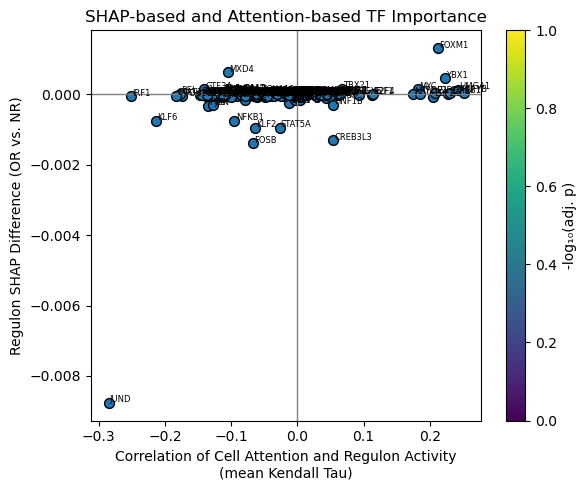

In [40]:
import matplotlib.pyplot as plt

plot_df = grouped.reset_index().merge(attention_corr_df, on="TF")
plot_df["log_p"] = -np.log10(plot_df["p_adj"] + 1e-10)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    x=plot_df["correlation"],
    y=plot_df["shap_diff"],
    # c=plot_df["log_p"],
    cmap="Reds",
    edgecolor='k',
    s=50
)

# Add text labels to all data points
for idx, row in plot_df.iterrows():
    plt.text(row["correlation"] + 0.002, row["shap_diff"] + 0.00001, row["TF"], fontsize=6)

# Optional: highlight TFs with larger font
for _, row in plot_df.nlargest(5, "log_p").iterrows():
    plt.text(row["correlation"] + 0.005, row["shap_diff"], row["TF"], fontsize=8, fontweight='bold')

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Correlation of Cell Attention and Regulon Activity\n(mean Kendall Tau)")
plt.ylabel("Regulon SHAP Difference (OR vs. NR)")
plt.colorbar(scatter, label="-log₁₀(adj. p)")
plt.title("SHAP-based and Attention-based TF Importance")
plt.tight_layout()
plt.show()


In [11]:
import os
import numpy as np
import torch
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import shap
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import median_abs_deviation


import pickle
#"/Users/kameronr/Documents/personal/Good lab/tcellMIL/src/MIL_downstream_72_mil_results.pkl"


# Flatten all attention weights
flattened_results = {}

for key, value in MIL_results['attention_weights'].items():
    if isinstance(value, list) and len(value) == 1:
        arr = value[0]  # Extract the NumPy array from the list
        flattened_results[key] = arr.flatten()
    else:
        print(f"Warning: unexpected format for {key}")

# === Helper: stratified patient-outcome sampling ===
def stratified_balanced_sample(adata, patient_col, outcome_col, n_total):
    group_keys = adata.obs[[patient_col, outcome_col]].drop_duplicates()
    group_labels = group_keys.values.tolist()
    n_per_group = n_total // len(group_labels)
    selected_indices = []

    for pid, outcome in group_labels:
        group = adata[(adata.obs[patient_col] == pid) & (adata.obs[outcome_col] == outcome)]
        if group.shape[0] == 0:
            continue  # skip empty groups
        replace = group.shape[0] < n_per_group
        sampled = np.random.choice(group.obs_names, size=n_per_group, replace=replace)
        selected_indices.extend(sampled)

    return adata[selected_indices]

# === Define global background pool (before per-patient filtering) ===
n_background = 7000
bg_adata_full = stratified_balanced_sample(adata, patient_col="patient_id", outcome_col="Response_3m", n_total=n_background)

# === Path to MIL models directory ===
# mil_root_dir = "/Users/kameronr/Documents/personal/Good lab/tcellMIL/src/mil"
# patient_dirs = [d for d in os.listdir(mil_root_dir) if os.path.isdir(os.path.join(mil_root_dir, d))]
mil_root_dir = "/Users/kristintsui/HA_MIL_model/tcellMIL/run_Sample_source_added_tcellMIL/mil"
patient_dirs = [d for d in os.listdir(mil_root_dir) if os.path.isdir(os.path.join(mil_root_dir, d))]
# === Intermediate data dictionary ===
intermediate_data = {}


















In [13]:
bg_adata_full.obs.Response_3m.value_counts()

Response_3m
OR    3815
NR    3161
Name: count, dtype: int64

In [14]:
# Flatten all attention weights
flattened_results = {}

for key, value in MIL_results['attention_weights'].items():
    if isinstance(value, list) and len(value) == 1:
        arr = value[0]  # Extract the NumPy array from the list
        flattened_results[key] = arr.flatten()
    else:
        print(f"Warning: unexpected format for {key}")

# === Helper: stratified patient-outcome sampling ===
def stratified_balanced_sample(adata, patient_col, outcome_col, n_total):
    group_keys = adata.obs[[patient_col, outcome_col]].drop_duplicates()
    group_labels = group_keys.values.tolist()
    n_per_group = n_total // len(group_labels)
    selected_indices = []

    for pid, outcome in group_labels:
        group = adata[(adata.obs[patient_col] == pid) & (adata.obs[outcome_col] == outcome)]
        if group.shape[0] == 0:
            continue  # skip empty groups
        replace = group.shape[0] < n_per_group
        sampled = np.random.choice(group.obs_names, size=n_per_group, replace=replace)
        selected_indices.extend(sampled)

    return adata[selected_indices]

# === Define global background pool (before per-patient filtering) ===
n_background = 7000
bg_adata_full = stratified_balanced_sample(adata, patient_col="patient_id", outcome_col="Response_3m", n_total=n_background)

# === Path to MIL models directory ===
# mil_root_dir = "/Users/kameronr/Documents/personal/Good lab/tcellMIL/src/mil"
# patient_dirs = [d for d in os.listdir(mil_root_dir) if os.path.isdir(os.path.join(mil_root_dir, d))]
mil_root_dir = "/Users/kristintsui/HA_MIL_model/tcellMIL/run_Sample_source_added_tcellMIL/mil"
patient_dirs = [d for d in os.listdir(mil_root_dir) if os.path.isdir(os.path.join(mil_root_dir, d))]
# === Intermediate data dictionary ===
intermediate_data = {}

# === Loop through each MIL model folder ===
for patient_folder in patient_dirs:
    patient_id = patient_folder.replace("patient_", "")
    model_path = os.path.join(mil_root_dir, patient_folder, "best_model.pth")

    # --- Load MIL model ---
    mil_model = AttentionMIL(input_dim=64, num_classes=2, hidden_dim=128, sample_source_dim=4)
    mil_model.load_state_dict(torch.load(model_path, map_location="cpu"))
    mil_model.eval()

    # --- Prepare test patient data ---
    adata_test = adata[adata.obs['patient_id'] == patient_id]
    if adata_test.shape[0] == 0:
        print(f"Skipping {patient_id} — no test data found.")
        continue

    X_test = adata_test.X.toarray() if not isinstance(adata_test.X, np.ndarray) else adata_test.X
    X_test_tensor = torch.FloatTensor(X_test)

    sample_source = adata_test.obs["Sample_source"].unique()[0]
    source_index = source_list.index(sample_source)
    sample_onehot = torch.FloatTensor(np.eye(len(source_list))[source_index]).unsqueeze(0)

    # --- Use consistent background excluding current patient ---
    adata_bg = bg_adata_full[bg_adata_full.obs['patient_id'] != patient_id]
    X_bg = adata_bg.X.toarray() if not isinstance(adata_bg.X, np.ndarray) else adata_bg.X
    X_bg_tensor = torch.FloatTensor(X_bg)

    # --- Wrap Autoencoder + MIL ---
    class AE_MIL_Wrapper(torch.nn.Module):
        def __init__(self, ae, mil, sample_source_tensor):
            super().__init__()
            self.ae = ae
            self.mil = mil
            self.sample_source_tensor = sample_source_tensor

        def forward(self, x):
            z = self.ae.encode(x)
            return self.mil([z], self.sample_source_tensor)

    combined_model = AE_MIL_Wrapper(autoencoder, mil_model, sample_onehot)

    # --- Run SHAP ---
    explainer = shap.GradientExplainer(combined_model, X_bg_tensor)
    shap_values = explainer.shap_values(X_test_tensor)

    # --- Save SHAP Class 1 (positive) ---
    shap_vals_class1 = shap_values[:, :, 1]
    mean_shap_vals_class1 = np.mean(np.abs(shap_vals_class1), axis=0)
    df_class1 = pd.DataFrame({'TF': tf_names, 'mean_abs_SHAP': mean_shap_vals_class1})
    df_class1 = df_class1.sort_values(by='mean_abs_SHAP', ascending=False)
    df_class1.to_csv(f"{mil_root_dir}/{patient_folder}_shap_TF_importance_class1_v2.csv", index=False)

    # --- Save SHAP Class 0 (negative) ---
    shap_vals_class0 = shap_values[:, :, 0]
    mean_shap_vals_class0 = np.mean(np.abs(shap_vals_class0), axis=0)
    df_class0 = pd.DataFrame({'TF': tf_names, 'mean_abs_SHAP': mean_shap_vals_class0})
    df_class0 = df_class0.sort_values(by='mean_abs_SHAP', ascending=False)
    df_class0.to_csv(f"{mil_root_dir}/{patient_folder}_shap_TF_importance_class0_v2.csv", index=False)

    # --- Directional SHAP Difference ---
    mean_signed_class1 = np.mean(shap_vals_class1, axis=0)
    mean_signed_class0 = np.mean(shap_vals_class0, axis=0)
    shap_diff = mean_signed_class1 - mean_signed_class0

    df_diff = pd.DataFrame({'TF': tf_names, 'SHAP_diff': shap_diff})
    df_diff.to_csv(f"{mil_root_dir}/{patient_folder}_top_directional_TFs_v2.csv", index=False)

    # --- Extract attention values ---
    attention_values = flattened_results.get(patient_id, None)
    if attention_values is None:
        print(f"No attention values found for {patient_id}")
        continue

    # --- Store all into intermediate dict ---
    intermediate_data[patient_id] = {
        'attention': np.array(attention_values),  # shape: (n_cells,)
        'shap_class0': shap_vals_class0,  # shape: (n_cells, n_genes)
        'shap_class1': shap_vals_class1,  # shape: (n_cells, n_genes)
        'cell_indices': adata_test.obs_names.tolist()
    }


    
    # --- Plot top directional TFs ---
    top_n = 29
    df_top = df_diff.reindex(df_diff.SHAP_diff.abs().sort_values(ascending=False).index).head(top_n)
    df_top = df_top[::-1]
    colors = ['green' if val > 0 else 'red' for val in df_top['SHAP_diff']]

    plt.figure(figsize=(10, 7))
    plt.barh(df_top['TF'], df_top['SHAP_diff'], color=colors)
    plt.axvline(0, color='black', linestyle='--')
    plt.title(f"Top {top_n} TFs Driving Prediction – Patient {patient_id}")
    plt.xlabel("Mean SHAP(Class 1) − Mean SHAP(Class 0)")
    plt.ylabel("TF")
    plt.tight_layout()
    plt.savefig(f"{mil_root_dir}/{patient_folder}_shap_directional_plot_v2.png")
    plt.close()

    print(f"✅ Processed SHAP for patient {patient_id}")


import pickle

# Path to save the intermediate object
save_path = "/Users/kristintsui/HA_MIL_model/tcellMIL/run_Sample_source_added_tcellMIL/mil_v2"

# Save to file
with open(save_path, "wb") as f:
    pickle.dump(intermediate_data, f)

print(f"✅ Saved intermediate_data to {save_path}")






✅ Processed SHAP for patient ac19
✅ Processed SHAP for patient ac26
✅ Processed SHAP for patient ac21
✅ Processed SHAP for patient ac28
✅ Processed SHAP for patient ac17
✅ Processed SHAP for patient ac10
✅ Processed SHAP for patient 15
✅ Processed SHAP for patient 12
✅ Processed SHAP for patient ac11
✅ Processed SHAP for patient ac29
✅ Processed SHAP for patient ac16
✅ Processed SHAP for patient ac20
✅ Processed SHAP for patient ac18
✅ Processed SHAP for patient ac27
✅ Processed SHAP for patient 13
✅ Processed SHAP for patient 14
✅ Processed SHAP for patient CAR122
✅ Processed SHAP for patient CAR139
✅ Processed SHAP for patient 07
✅ Processed SHAP for patient 09
✅ Processed SHAP for patient ac05
✅ Processed SHAP for patient ac02
✅ Processed SHAP for patient ac34
✅ Processed SHAP for patient ac33
✅ Processed SHAP for patient 08
✅ Processed SHAP for patient Pt245
✅ Processed SHAP for patient 01
✅ Processed SHAP for patient ac32
✅ Processed SHAP for patient ac03
✅ Processed SHAP for pati

IsADirectoryError: [Errno 21] Is a directory: '/Users/kristintsui/HA_MIL_model/tcellMIL/run_Sample_source_added_tcellMIL/mil_v2'

In [20]:
intermediate_data['ac19']

{'attention': array([7.95903106e-05, 6.27792906e-03, 6.52148738e-04, 4.45020123e-05,
        3.14880490e-05, 1.02583535e-05, 1.18345570e-05, 3.33993882e-03,
        1.02876920e-05, 1.02924705e-05, 7.73021966e-05, 2.90989992e-03,
        2.93390453e-03, 1.07177866e-05, 3.99101060e-03, 1.01698242e-05,
        2.91829370e-03, 1.83101965e-05, 2.88009833e-05, 3.46910383e-05,
        2.72683010e-05, 1.96645604e-04, 3.13710095e-03, 2.93598423e-04,
        6.73803827e-03, 1.01621563e-05, 2.00984371e-03, 4.58432222e-03,
        1.34604215e-05, 1.86999259e-05, 1.70286011e-03, 3.40333849e-04,
        1.75909838e-04, 5.66389412e-03, 4.09003394e-03, 1.86939165e-03,
        3.87818582e-05, 1.62798766e-04, 4.21508594e-05, 9.44761385e-04,
        1.16807623e-05, 1.73729472e-03, 1.04233386e-05, 3.61601869e-03,
        2.32871110e-03, 1.69258899e-04, 4.07514053e-05, 4.76101268e-05,
        1.04692299e-05, 1.34707270e-05, 3.60350590e-03, 4.68179490e-03,
        3.16821295e-03, 3.07959854e-03, 1.07892511e

In [9]:
import pickle
with open("/Users/kristintsui/HA_MIL_model/tcellMIL/data/MIL_downstream_72_mil_results_attention_weights.pkl", "rb") as f:
    MIL_results = pickle.load(f)
attention_df = pd.DataFrame(MIL_results["attention_weights"])#, index=adata.obs_names, columns=adata.var_names)



In [18]:
# Save to file
with open("/Users/kristintsui/HA_MIL_model/tcellMIL/run_Sample_source_added_tcellMIL/mil/shap_scores.pkl", "wb") as f:
    pickle.dump(intermediate_data, f)

In [10]:
import pandas as pd
import scipy
from statsmodels.stats.multitest import multipletests

import glob



meta = adata.obs[["patient_id", "Response_3m"]].copy()
meta["response_label"] = meta["Response_3m"].map({"OR": 1, "NR": 0})
meta = meta.dropna()

# Load SHAP files
shap_files = glob.glob("/Users/kristintsui/HA_MIL_model/tcellMIL/run_Sample_source_added_tcellMIL/mil/*_v2.csv")
shap_all = []

for f in shap_files:
    df = pd.read_csv(f)
    pid = f.split("/")[-1].split("_")[1]  # adjust if naming is different
    df["patient_id"] = pid
    shap_all.append(df)

shap_df = pd.concat(shap_all)
shap_df = shap_df.merge(meta.reset_index(), on="patient_id")

grouped = shap_df.groupby(["TF", "response_label"])["mean_abs_SHAP"].mean().unstack()
grouped["shap_diff"] = grouped[1] - grouped[0]




/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_37260/2019414273.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = shap_df.groupby(["TF", "response_label"])["mean_abs_SHAP"].mean().unstack()


In [23]:
grouped

response_label,0,1,shap_diff,pval,p_adj
TF,,,,,
ATF1,0.000282,0.000303,0.000021,NaN,NaN
ATF2,0.000330,0.000335,0.000004,NaN,NaN
ATF3,0.000351,0.000342,-0.000009,NaN,NaN
ATF5,0.001395,0.001147,-0.000248,NaN,NaN
BACH2,0.000301,0.000342,0.000041,NaN,NaN
...,...,...,...,...,...
ZNF354B,0.000311,0.000281,-0.000030,NaN,NaN
ZNF354C,0.000153,0.000144,-0.000009,NaN,NaN
ZNF367,0.000336,0.000343,0.000008,NaN,NaN


In [33]:
df_plot

,FOSB,KLF2,JUN,FOS,JUND,HMGA1,CREB3L3,KLF6,GTF3A,FOXM1,...,ETS1,ELK4,HNF1B,TLX2,ATF5,MAFG,LEF1,PPARG,E2F2,FOXP3
01,0.026212,-0.000846,0.011892,0.006905,-0.006988,-0.004675,-0.001923,-0.003465,-0.000737,0.000151,...,0.000164,-0.000133,-0.000429,0.000187,0.000572,-0.000006,-0.000597,-0.000384,0.000375,-0.000017
02,0.005402,-0.017526,0.007676,0.006330,-0.023757,-0.030750,-0.023230,-0.007193,-0.003740,0.023773,...,-0.001602,0.000800,-0.000100,0.000186,-0.001638,0.001709,-0.000748,-0.001857,0.000563,0.001087
03,0.006796,0.012385,0.003766,-0.000745,-0.008254,0.000320,-0.000421,0.001414,-0.004110,-0.012021,...,0.000281,-0.000227,0.000066,0.000339,-0.000289,-0.000140,0.001200,0.000286,-0.000343,-0.000462
04,0.020440,-0.017454,-0.005304,-0.003478,-0.004432,-0.004655,0.005688,-0.026254,0.003946,-0.013275,...,-0.000996,0.002316,0.001724,0.000556,0.001196,0.000869,0.000684,-0.000086,0.001813,0.001443
05,0.013214,0.008614,0.022659,0.012129,0.007003,-0.000209,0.007115,-0.000845,-0.002454,-0.008646,...,0.000370,-0.000374,0.000754,0.000079,0.000384,-0.000107,-0.000167,-0.000171,-0.000161,-0.000024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ac33,0.020316,0.016043,0.008735,0.008695,-0.004486,-0.010222,0.008417,-0.008119,-0.000028,0.000151,...,0.000231,-0.000039,-0.000023,0.000412,0.000483,-0.000220,-0.000132,0.000266,0.000318,0.000121
ac34,0.010156,0.004477,0.001233,-0.001823,-0.002770,-0.003391,0.012145,-0.006904,0.001928,-0.000916,...,0.000522,-0.000408,0.000469,0.000891,0.000286,-0.000366,-0.000447,0.000406,-0.000022,0.000104
ac37,0.023224,0.000566,0.015004,0.013961,-0.001607,-0.007126,-0.003839,-0.008427,-0.003800,0.001919,...,0.000601,-0.000368,0.000174,0.000903,0.000505,-0.000277,-0.000620,-0.000608,0.000303,0.000114
ac38,0.044791,0.004829,0.002868,-0.004952,-0.019369,-0.019400,0.004221,-0.011417,0.001001,0.015594,...,-0.001018,0.000604,-0.000145,0.000558,0.000899,-0.000445,-0.001348,0.000860,0.003442,0.000431


In [32]:
plot_df

,TF,0,1,shap_diff,pval,p_adj,gene_name,correlation,log_p
0,ATF1,0.000282,0.000303,0.000021,NaN,NaN,NaN,0.057804,NaN
1,ATF2,0.000330,0.000335,0.000004,NaN,NaN,NaN,-0.013131,NaN
2,ATF3,0.000351,0.000342,-0.000009,NaN,NaN,NaN,-0.112172,NaN
3,ATF5,0.001395,0.001147,-0.000248,NaN,NaN,NaN,-0.012884,NaN
4,BACH2,0.000301,0.000342,0.000041,NaN,NaN,NaN,-0.114139,NaN
...,...,...,...,...,...,...,...,...,...
149,ZNF354B,0.000311,0.000281,-0.000030,NaN,NaN,NaN,-0.009033,NaN
150,ZNF354C,0.000153,0.000144,-0.000009,NaN,NaN,NaN,-0.013110,NaN
151,ZNF367,0.000336,0.000343,0.000008,NaN,NaN,NaN,0.045408,NaN
152,ZNF407,0.000492,0.000485,-0.000007,NaN,NaN,NaN,-0.076264,NaN


In [11]:
# Optional: p-values using Mann–Whitney U

all_attns = np.concatenate([np.hstack(attention_df[p]).flatten() for p in attention_df.keys()])
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

def compute_p(tf):
    or_vals = shap_df[(shap_df["TF"] == tf) & (shap_df["response_label"] == 1)]["mean_abs_SHAP"]
    nr_vals = shap_df[(shap_df["TF"] == tf) & (shap_df["response_label"] == 0)]["mean_abs_SHAP"]
    if len(or_vals) < 3 or len(nr_vals) < 3:
        return 1.0
    return mannwhitneyu(or_vals, nr_vals, alternative="two-sided").pvalue

grouped["pval"] = grouped.index.to_series().apply(compute_p)
grouped["p_adj"] = multipletests(grouped["pval"], method="fdr_bh")[1]

def find_correlation_between_attn_and_gene(attn_weights, adata):
    correlations = []
    p_values = []
    correlations_kendall = []
    p_values_kendall = []

    for i in range(adata.X.shape[1]):
        gene_expr = np.array(adata.X[:, i]).flatten()
        corr, p_val = scipy.stats.spearmanr(all_attns, gene_expr)
        # do kendall tau as well
        corr_kendall, p_val_kendall = scipy.stats.kendalltau(all_attns, gene_expr)
        correlations.append(corr)
        p_values.append(p_val)
        correlations_kendall.append(corr_kendall)
        p_values_kendall.append(p_val_kendall)

    # multiple testing 
    _, p_values_adj = multipletests(p_values, method='fdr_bh')[:2]
    _, p_values_kendall_adj = multipletests(p_values_kendall, method='fdr_bh')[:2]

    results = pd.DataFrame({
        'correlation': correlations,
        'p_value': p_values,
        'p_value_adjusted': p_values_adj,
        'correlation_kendall': correlations_kendall,
        'p_value_kendall': p_values_kendall,
        'p_value_kendall_adjusted': p_values_kendall_adj
    })

    return results
results = find_correlation_between_attn_and_gene(attention_df, adata)

In [12]:
attention_corr_df = pd.DataFrame(results["correlation"], columns=["gene_name", "correlation"])

In [13]:
attention_corr_df["TF"] = adata.var_names
attention_corr_df.head()
# Join with TF activity from AnnData

plot_df = grouped.reset_index().merge(attention_corr_df, on="TF")
plot_df["log_p"] = -np.log10(plot_df["p_adj"] + 1e-10)

In [17]:
plot_df

,TF,0,1,shap_diff,pval,p_adj,gene_name,correlation,log_p
0,ATF1,0.000282,0.000303,0.000021,NaN,NaN,NaN,0.057804,NaN
1,ATF2,0.000330,0.000335,0.000004,NaN,NaN,NaN,-0.013131,NaN
2,ATF3,0.000351,0.000342,-0.000009,NaN,NaN,NaN,-0.112172,NaN
3,ATF5,0.001395,0.001147,-0.000248,NaN,NaN,NaN,-0.012884,NaN
4,BACH2,0.000301,0.000342,0.000041,NaN,NaN,NaN,-0.114139,NaN
...,...,...,...,...,...,...,...,...,...
149,ZNF354B,0.000311,0.000281,-0.000030,NaN,NaN,NaN,-0.009033,NaN
150,ZNF354C,0.000153,0.000144,-0.000009,NaN,NaN,NaN,-0.013110,NaN
151,ZNF367,0.000336,0.000343,0.000008,NaN,NaN,NaN,0.045408,NaN
152,ZNF407,0.000492,0.000485,-0.000007,NaN,NaN,NaN,-0.076264,NaN


In [50]:
# Calculate average SHAP_diff for each TF
tf_avg_shap = df_long.groupby('TF')['SHAP_diff'].median().reset_index()
print(f"Average SHAP difference by TF:\n{tf_avg_shap}")

Average SHAP difference by TF:
          TF  SHAP_diff
0       ATF1  -0.000008
1       ATF2   0.000016
2       ATF3   0.000045
3       ATF5   0.000271
4      BACH2  -0.000068
..       ...        ...
149  ZNF354B  -0.000021
150  ZNF354C  -0.000031
151   ZNF367  -0.000031
152   ZNF407  -0.000008
153   ZNF580  -0.000141

[154 rows x 2 columns]


In [58]:
# Calculate average SHAP_diff for each TF
tf_avg_shap_unweighted = df_long_unweighted.groupby('TF')['SHAP_diff'].median().reset_index()
print(f"Average SHAP difference (unweighted) by TF:\n{tf_avg_shap_unweighted}")

Average SHAP difference (unweighted) by TF:
          TF     SHAP_diff
0       ATF1 -4.906608e-05
1       ATF2 -4.372069e-06
2       ATF3 -1.910015e-04
3       ATF5 -1.294121e-05
4      BACH2  3.558234e-05
..       ...           ...
149  ZNF354B  4.806382e-05
150  ZNF354C  6.395478e-07
151   ZNF367 -3.961836e-05
152   ZNF407  8.752208e-05
153   ZNF580  9.171043e-05

[154 rows x 2 columns]


/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_37260/2684218139.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(


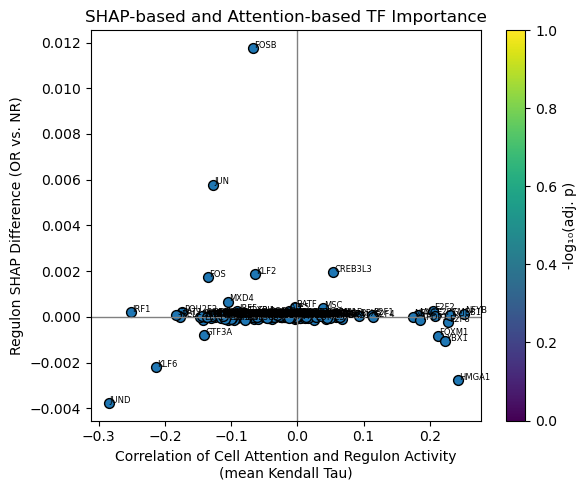

In [53]:
import matplotlib.pyplot as plt

plot_df = tf_avg_shap.reset_index().merge(attention_corr_df, on="TF")
# plot_df["log_p"] = -np.log10(plot_df["p_adj"] + 1e-10)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    x=plot_df["correlation"],
    y=plot_df["SHAP_diff"],
    # c=plot_df["log_p"],
    cmap="Reds",
    edgecolor='k',
    s=50
)

# Add text labels to all data points
for idx, row in plot_df.iterrows():
    plt.text(row["correlation"] + 0.002, row["SHAP_diff"] + 0.00001, row["TF"], fontsize=6)

# Optional: highlight TFs with larger font
# for _, row in plot_df.nlargest(5, "log_p").iterrows():
#     plt.text(row["correlation"] + 0.005, row["shap_diff"], row["TF"], fontsize=8, fontweight='bold')

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Correlation of Cell Attention and Regulon Activity\n(mean Kendall Tau)")
plt.ylabel("Regulon SHAP Difference (OR vs. NR)")
plt.colorbar(scatter, label="-log₁₀(adj. p)")
plt.title("SHAP-based and Attention-based TF Importance")
plt.tight_layout()
plt.show()


/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_37260/4011351122.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(


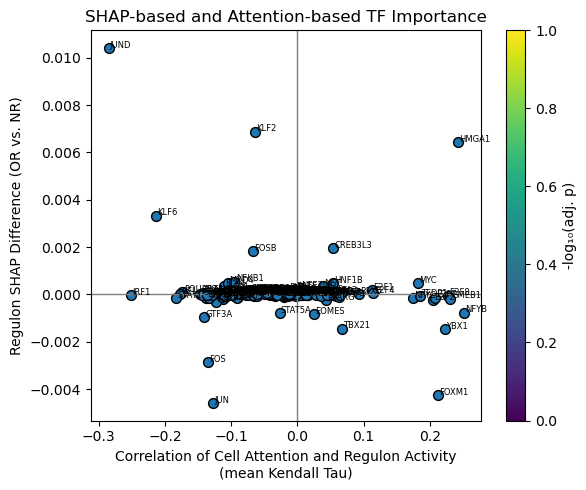

In [59]:
import matplotlib.pyplot as plt

plot_df = tf_avg_shap_unweighted.reset_index().merge(attention_corr_df, on="TF")
# plot_df["log_p"] = -np.log10(plot_df["p_adj"] + 1e-10)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    x=plot_df["correlation"],
    y=plot_df["SHAP_diff"],
    # c=plot_df["log_p"],
    cmap="Reds",
    edgecolor='k',
    s=50
)

# Add text labels to all data points
for idx, row in plot_df.iterrows():
    plt.text(row["correlation"] + 0.002, row["SHAP_diff"] + 0.00001, row["TF"], fontsize=6)

# Optional: highlight TFs with larger font
# for _, row in plot_df.nlargest(5, "log_p").iterrows():
#     plt.text(row["correlation"] + 0.005, row["shap_diff"], row["TF"], fontsize=8, fontweight='bold')

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Correlation of Cell Attention and Regulon Activity\n(mean Kendall Tau)")
plt.ylabel("Regulon SHAP Difference (OR vs. NR)")
plt.colorbar(scatter, label="-log₁₀(adj. p)")
plt.title("SHAP-based and Attention-based TF Importance")
plt.tight_layout()
plt.show()


In [15]:
# Save to file
with open("/Users/kristintsui/HA_MIL_model/tcellMIL/run_Sample_source_added_tcellMIL/mil/shap_scores.pkl", "rb") as f:
    intermediate_data = pickle.load(f)

In [16]:
intermediate_data['ac19']

{'attention': array([7.95903106e-05, 6.27792906e-03, 6.52148738e-04, 4.45020123e-05,
        3.14880490e-05, 1.02583535e-05, 1.18345570e-05, 3.33993882e-03,
        1.02876920e-05, 1.02924705e-05, 7.73021966e-05, 2.90989992e-03,
        2.93390453e-03, 1.07177866e-05, 3.99101060e-03, 1.01698242e-05,
        2.91829370e-03, 1.83101965e-05, 2.88009833e-05, 3.46910383e-05,
        2.72683010e-05, 1.96645604e-04, 3.13710095e-03, 2.93598423e-04,
        6.73803827e-03, 1.01621563e-05, 2.00984371e-03, 4.58432222e-03,
        1.34604215e-05, 1.86999259e-05, 1.70286011e-03, 3.40333849e-04,
        1.75909838e-04, 5.66389412e-03, 4.09003394e-03, 1.86939165e-03,
        3.87818582e-05, 1.62798766e-04, 4.21508594e-05, 9.44761385e-04,
        1.16807623e-05, 1.73729472e-03, 1.04233386e-05, 3.61601869e-03,
        2.32871110e-03, 1.69258899e-04, 4.07514053e-05, 4.76101268e-05,
        1.04692299e-05, 1.34707270e-05, 3.60350590e-03, 4.68179490e-03,
        3.16821295e-03, 3.07959854e-03, 1.07892511e

In [18]:
#the attention weights are different for every LOOV model! so need to extract cell attention weights (scores) from each LOOV MIL model.
import pickle
import os
import numpy as np

# def load_attention_weights(result_dir):
#     """
#     Load attention weights per patient from LOOCV results.

#     Parameters:
#     - result_dir: path to the `results` directory where loocv_results.pkl is stored

#     Returns:
#     - dict: patient_id -> list of attention weights arrays (one per cell)
#     """
#     loocv_results_path = os.path.join(result_dir, 'loocv_results.pkl')
    
#     if not os.path.exists(loocv_results_path):
#         raise FileNotFoundError(f"{loocv_results_path} not found.")
    
#     with open(loocv_results_path, 'rb') as f:
#         results = pickle.load(f)
    
#     attention_dict = results.get('attention_weights', {})
#     return attention_dict

# attention_dict = load_attention_weights("/Users/kristintsui/HA_MIL_model/tcellMIL/run_Sample_source_added_tcellMIL/mil")




# #add the LOOCV cell attention weights to the intermediate data object
# # Replace attention values in intermediate_data with those from attention_dict
# for patient_id, data in intermediate_data.items():
#     if patient_id not in attention_dict:
#         print(f"⚠️ No new attention data for patient {patient_id}; skipping.")
#         continue

#     new_attention = np.array(attention_dict[patient_id][0])
    
#     if len(new_attention) != len(data['cell_indices']):
#         print(f"❌ Mismatch in number of attention values for patient {patient_id}: "
#               f"{len(new_attention)} vs {len(data['cell_indices'])}")
#         continue

#     # Update attention
#     intermediate_data[patient_id]['attention'] = new_attention

# print("✅ intermediate_data updated with attention_dict")





#merge the intermediate data into the adata (a copy of adata)
# adata_w_attention_and_shap = adata[:].copy()

import pandas as pd

# Initialize containers for merged SHAP values
all_shap_class0 = []
all_shap_class1 = []
all_cell_indices = []

# Add attention and prepare SHAP values for merging
for patient_id, pdata in intermediate_data.items():
    cell_ids = pdata['cell_indices']
    
    # 1. Insert attention into adata.obs
    adata.obs.loc[cell_ids, 'attention'] = pdata['attention']

    # 2. Append SHAP data to list (for all cells)
    df_class0 = pd.DataFrame(pdata['shap_class0'], index=cell_ids, columns=tf_names)
    df_class1 = pd.DataFrame(pdata['shap_class1'], index=cell_ids, columns=tf_names)

    all_shap_class0.append(df_class0)
    all_shap_class1.append(df_class1)
    all_cell_indices.extend(cell_ids)

# Concatenate all SHAP values across patients
shap_class0_df = pd.concat(all_shap_class0, axis=0)
shap_class1_df = pd.concat(all_shap_class1, axis=0)

# Optional: sort by index to match adata
shap_class0_df = shap_class0_df.loc[adata.obs_names.intersection(shap_class0_df.index)]
shap_class1_df = shap_class1_df.loc[adata.obs_names.intersection(shap_class1_df.index)]

# 3. Store SHAP values in obsm
adata.obsm["shap_class0"] = shap_class0_df
adata.obsm["shap_class1"] = shap_class1_df

print("✅ Merged attention and SHAP values into adata_w_attention_and_shap.")





#save adata_w_attention_and_shap

# Save the AnnData object
adata.write("/Users/kristintsui/HA_MIL_model/tcellMIL/run_Sample_source_added_tcellMIL/cell_atlas_axicel_IP_scenic_tf_matrix_added_v2_high_attention_cells_w_attention_and_shap_values_v2.h5ad")


✅ Merged attention and SHAP values into adata_w_attention_and_shap.


In [21]:
adata.obs.attention

cell_barcode
Good_Pt237-B_Product-AAACGGGAGACCTTTG-1    0.000115
Good_Pt237-B_Product-AAACGGGCATGAGCGA-1    0.000114
Good_Pt237-B_Product-AAACGGGGTAGTAGTA-1    0.000116
Good_Pt237-B_Product-AAACGGGTCTAGCACA-1    0.000120
Good_Pt237-B_Product-AAAGATGTCATTGCCC-1    0.000115
                                             ...   
Maurer_CAR142_IP.TTTATGCGTCTCACCT.1        0.000037
Maurer_CAR142_IP.TTTCCTCTCTAACTTC.1        0.000042
Maurer_CAR142_IP.TTTGCGCTCTTAACCT.1        0.000041
Maurer_CAR142_IP.TTTGGTTGTCTTGCGG.1        0.000038
Maurer_CAR142_IP.TTTGTCATCAACGAAA.1        0.000039
Name: attention, Length: 35937, dtype: float32

In [41]:
adata_w_attention_and_shap

AnnData object with n_obs × n_vars = 35937 × 154
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'construct', 'sample', 'patient_id', 'timepoint_detail', 'timepoint', 'barcode', 'nCount_ADT', 'nFeature_ADT', 'clonotype', 'pt_clonotype', 'CAR_mRNA', 'Sample_id', 'percent.mito', 'Sample_source', 'nCount_SCT', 'nFeature_SCT', 'new_patient_id', 'ICANS_over_3', 'max_ICANS', 'max_CRS', 'tumor_burden_SPD', 'Response_3m_og', 'Response_6m', 'SCT_snn_res.0.25', 'RNA_clusters', 'S.Score', 'G2M.Score', 'Phase', 'azimuth1.score', 'azimuth1', 'azimuth2.score', 'azimuth2', 'scenic_snn_res.5', 'seurat_clusters', 'ID', 'Sample_source.x', 'max_ICANS.x', 'max_CRS.x', 'tumor_burden_SPD.x', 'Response_3m_og.x', 'Response_6m.x', 'therapy', 'age', 'gender', 'max_ICANS.y', 'max_CRS.y', 'LDH', 'tumor_burden_SPD.y', 'Response_30d', 'Response_30d_og', 'Response_3m', 'Response_3m_og.y', 'Response_6m.y', 'Sample_source.y', 'cd4_cd8', 'cell_type', 'cell_type_pred_protein', 'cd4_cd8_rna', 'cell_type_rna', 'cell_

In [27]:
adata_w_attention_and_shap.obsm['shap_class0']
# adata_w_attention_and_shap.obsm['shap_class1']
# adata_w_attention_and_shap.obs.attention


,ATF1,ATF2,ATF3,ATF5,BACH2,BATF,BCL11A,BHLHE41,CEBPA,CEBPB,...,ZBTB17,ZBTB20,ZBTB25,ZNF225,ZNF35,ZNF354B,ZNF354C,ZNF367,ZNF407,ZNF580
Good_Pt237-B_Product-AAACGGGAGACCTTTG-1,-0.000857,-0.001557,0.005648,0.005317,0.000309,-0.007192,-0.000825,-0.000280,0.002798,0.000968,...,0.000178,0.000024,0.000145,1.746041e-02,0.000105,0.000086,0.000107,0.000203,-0.001167,0.001227
Good_Pt237-B_Product-AAACGGGCATGAGCGA-1,0.000797,0.002131,0.000358,0.000392,-0.000054,0.000215,0.000075,0.000186,0.000149,-0.000104,...,0.000404,0.000096,0.000302,-1.878895e-04,0.000024,0.000226,0.000071,-0.000016,-0.000395,-0.000268
Good_Pt237-B_Product-AAACGGGGTAGTAGTA-1,0.002125,-0.000748,0.000020,-0.000172,-0.000027,-0.003571,-0.000161,0.000159,-0.000090,0.000012,...,0.000929,-0.001469,-0.000415,-3.206269e-04,-0.000077,-0.000187,0.000216,-0.000112,-0.009029,0.001934
Good_Pt237-B_Product-AAACGGGTCTAGCACA-1,0.000744,0.000340,-0.000572,0.000360,0.000109,-0.000333,0.000038,-0.000084,-0.000126,-0.000151,...,0.000349,-0.000018,-0.000327,-1.675875e-05,0.000098,0.000019,0.000006,0.000220,-0.000256,0.000611
Good_Pt237-B_Product-AAAGATGTCATTGCCC-1,-0.000201,-0.000034,0.000530,0.000497,0.000119,0.004778,-0.000044,0.000026,0.000037,0.000790,...,0.000097,-0.000009,-0.000245,4.281185e-04,-0.000270,0.000061,0.000127,-0.000006,-0.000284,-0.000189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Maurer_CAR142_IP.TTTATGCGTCTCACCT.1,-0.000101,0.000252,0.000067,-0.000277,0.000111,0.000597,0.000051,-0.000008,0.000092,-0.000036,...,0.000120,0.000080,-0.000022,7.449930e-05,0.000021,0.000026,-0.000005,-0.000013,-0.000516,0.000073
Maurer_CAR142_IP.TTTCCTCTCTAACTTC.1,-0.000287,0.000117,0.000665,-0.001990,0.000034,-0.007920,0.000109,0.000146,0.000724,0.000235,...,0.000768,-0.002013,0.000189,3.515624e-07,0.000917,0.000119,-0.000023,0.000068,0.000873,0.000530
Maurer_CAR142_IP.TTTGCGCTCTTAACCT.1,0.000492,-0.000409,0.000171,-0.001211,0.000516,0.001055,-0.000463,0.000109,0.000370,0.000047,...,-0.000503,-0.000455,-0.000070,-8.182954e-05,0.000121,-0.000008,0.001215,-0.000067,0.001115,0.000338
Maurer_CAR142_IP.TTTGGTTGTCTTGCGG.1,-0.000336,-0.000353,0.000523,-0.001507,-0.000027,-0.004511,0.000031,-0.000165,-0.000602,0.000011,...,0.000902,0.000083,-0.000107,-1.860933e-04,-0.000094,0.000097,0.000018,0.000319,-0.001409,0.000507


In [56]:
df_weighted_class1

,ATF1,ATF2,ATF3,ATF5,BACH2,BATF,BCL11A,BHLHE41,CEBPA,CEBPB,...,ZBTB17,ZBTB20,ZBTB25,ZNF225,ZNF35,ZNF354B,ZNF354C,ZNF367,ZNF407,ZNF580
01,-0.000003,0.000050,0.000187,0.000325,-2.948699e-05,-0.000100,-2.551785e-05,5.550824e-07,0.000011,7.255098e-08,...,-0.000031,0.000031,-0.000018,0.000042,-1.545109e-05,-0.000043,-0.000023,-0.000059,-0.000018,0.000081
02,-0.000113,0.000103,0.000120,-0.000806,-1.653402e-04,0.001365,6.470810e-05,2.993189e-05,0.000015,2.406360e-04,...,-0.000285,0.000081,-0.000062,0.000173,-2.170830e-04,0.000236,-0.000038,0.000181,0.000775,-0.000588
03,0.000039,-0.000020,-0.000085,-0.000139,3.193063e-05,-0.000053,-2.997625e-05,4.474364e-07,0.000009,-1.147543e-05,...,0.000016,-0.000044,0.000036,0.000053,2.539883e-05,0.000028,0.000011,-0.000071,-0.000090,0.000240
04,0.000037,0.000074,0.000195,0.000634,7.590641e-04,0.000760,-9.369359e-05,-2.313334e-05,-0.000108,8.508612e-05,...,-0.000288,0.000055,-0.000034,-0.000150,-8.839535e-05,0.000045,-0.000077,0.000065,0.000241,-0.000079
05,-0.000016,0.000030,-0.000004,0.000201,-9.092489e-06,-0.000363,-1.943598e-05,1.515847e-05,0.000044,-1.977052e-06,...,0.000105,0.000007,-0.000014,-0.000034,1.734938e-05,0.000011,-0.000032,0.000071,-0.000090,0.000419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ac33,-0.000003,-0.000002,0.000060,0.000215,-4.319267e-07,0.000434,-5.435455e-07,2.979325e-06,0.000131,4.094926e-05,...,-0.000001,0.000011,-0.000027,0.000005,-1.598112e-06,-0.000016,-0.000015,-0.000009,0.000017,-0.000091
ac34,0.000027,0.000007,0.000061,0.000131,3.030613e-06,0.000422,-1.311773e-05,8.333145e-06,-0.000005,-2.975150e-05,...,-0.000031,0.000092,-0.000017,0.000041,2.973702e-06,0.000091,0.000002,-0.000081,-0.000108,0.000131
ac37,-0.000006,0.000024,0.000126,0.000186,-2.993985e-05,0.000165,-6.927313e-07,2.933267e-05,-0.000042,-1.119066e-05,...,-0.000043,0.000087,-0.000022,-0.000001,-1.279101e-05,-0.000001,-0.000039,-0.000019,-0.000125,-0.000078
ac38,0.000053,-0.000152,0.000157,0.000431,-1.781173e-04,-0.000213,-2.428188e-05,1.511292e-04,0.000002,9.772429e-06,...,-0.000179,0.000096,-0.000067,0.000149,1.648489e-04,-0.000115,-0.000005,0.000013,0.000494,-0.000384


In [55]:
df_unweighted_class1

,ATF1,ATF2,ATF3,ATF5,BACH2,BATF,BCL11A,BHLHE41,CEBPA,CEBPB,...,ZBTB17,ZBTB20,ZBTB25,ZNF225,ZNF35,ZNF354B,ZNF354C,ZNF367,ZNF407,ZNF580
01,-0.000019,0.000018,0.000166,0.000377,-0.000009,0.000446,-0.000015,0.000017,0.000043,0.000009,...,0.000027,0.000008,-0.000015,-0.000003,-0.000033,0.000016,1.764006e-05,-0.000096,-0.000005,0.000101
02,-0.000023,0.000002,-0.000245,-0.000174,-0.000036,0.000331,0.000011,0.000012,0.000091,-0.000078,...,-0.000040,0.000010,0.000060,-0.000019,-0.000012,0.000171,3.368972e-05,0.000083,0.000340,-0.000067
03,0.000070,-0.000026,-0.000192,-0.000279,0.000031,-0.000288,-0.000019,-0.000028,0.000072,-0.000041,...,0.000258,-0.000051,0.000087,0.000035,0.000049,0.000013,3.919991e-07,-0.000111,-0.000200,0.000480
04,-0.000010,-0.000026,-0.000080,0.000184,0.000003,0.000573,0.000002,0.000010,-0.000061,-0.000079,...,-0.000074,-0.000072,0.000101,-0.000025,-0.000045,0.000078,3.875271e-05,0.000064,0.000589,-0.000109
05,0.000016,0.000032,-0.000151,0.000316,0.000021,-0.000885,-0.000034,0.000025,0.000122,0.000017,...,0.000166,-0.000084,0.000018,-0.000069,0.000034,0.000022,5.523161e-05,-0.000070,-0.000022,0.000750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ac33,-0.000010,-0.000011,-0.000062,0.000047,0.000030,0.000020,-0.000003,0.000014,0.000153,0.000032,...,0.000058,-0.000029,-0.000004,-0.000002,0.000005,0.000012,-1.188513e-05,-0.000009,0.000037,0.000036
ac34,0.000004,-0.000076,-0.000114,-0.000510,0.000051,-0.000320,-0.000005,0.000026,-0.000044,-0.000083,...,0.000069,0.000064,0.000032,-0.000064,0.000069,0.000141,-5.040735e-05,-0.000039,-0.000109,0.000346
ac37,-0.000028,0.000019,0.000096,0.000216,-0.000026,0.000020,0.000008,0.000029,-0.000030,-0.000019,...,-0.000016,0.000083,-0.000012,0.000025,-0.000003,-0.000009,-1.279786e-05,-0.000023,-0.000140,-0.000054
ac38,-0.000065,0.000024,-0.000279,-0.000658,-0.000147,-0.000970,0.000027,0.000069,-0.000049,-0.000017,...,0.000162,-0.000058,0.000060,0.000007,0.000036,-0.000037,-2.372305e-06,-0.000014,-0.000130,0.000405


/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_37260/2682814010.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata_w_attention_and_shap.obs.groupby('patient_id')
/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_37260/2682814010.py:170: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_37260/2682814010.py:170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


FileNotFoundError: [Errno 2] No such file or directory: '/Users/kameronr/Documents/personal/Good lab/tcellMIL/diff_attention_unweight_shap_scores_violin_plot_all_patients6_median_sorted_v2.pdf'

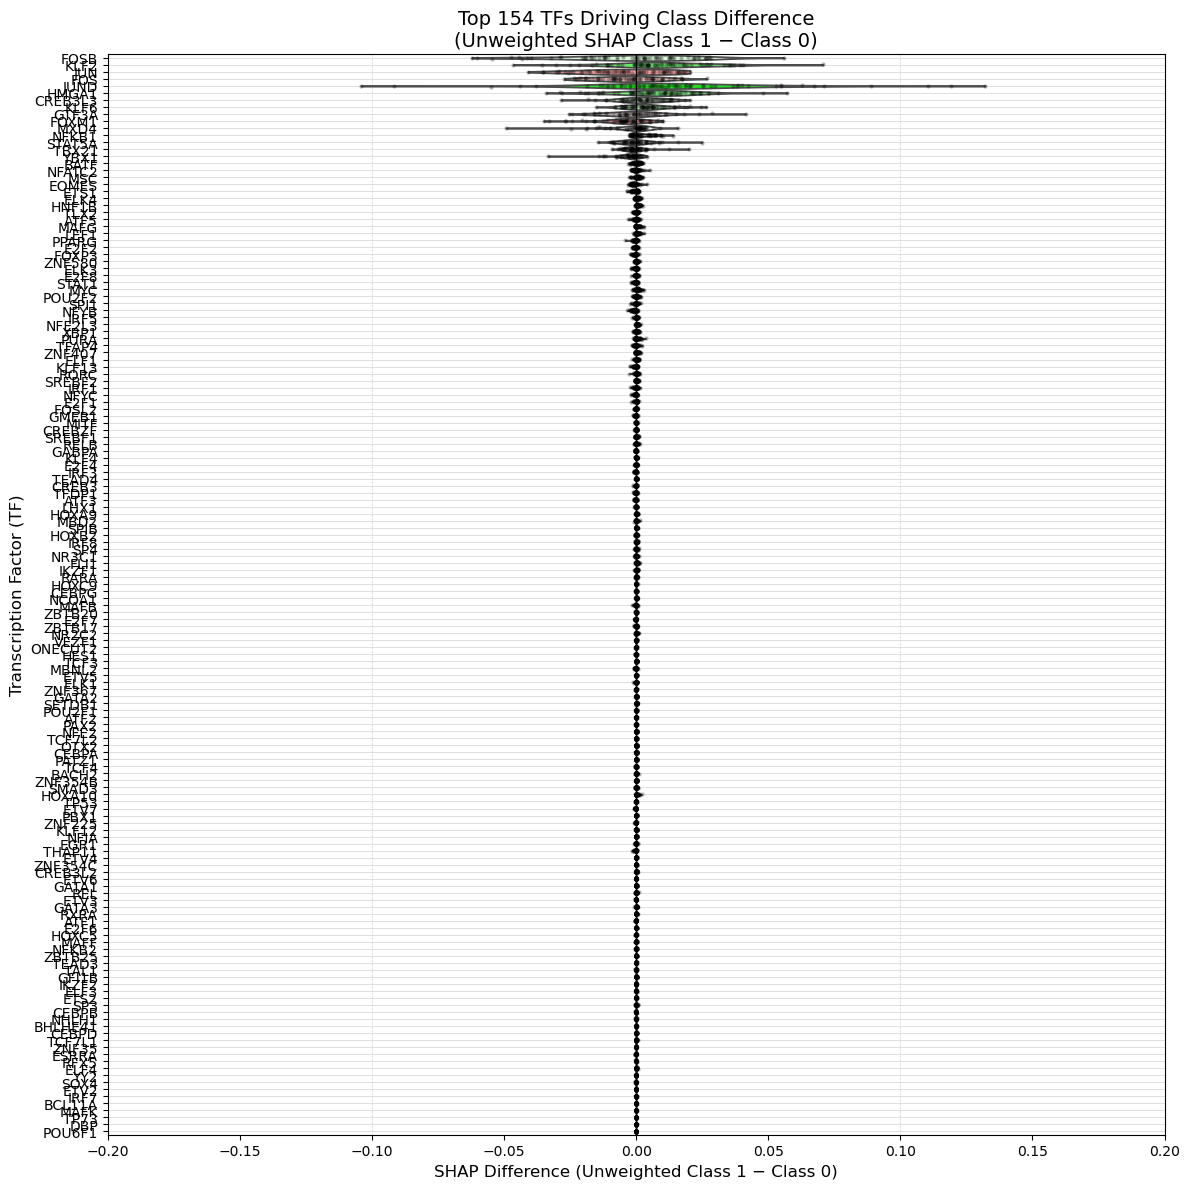

In [57]:
adata_w_attention_and_shap = sc.read_h5ad("/Users/kristintsui/HA_MIL_model/tcellMIL/run_Sample_source_added_tcellMIL/cell_atlas_axicel_IP_scenic_tf_matrix_added_v2_high_attention_cells_w_attention_and_shap_values_v2.h5ad")



#use the shap scores (each class separately) and attention scores to compute weighted average shap scores for each patient for each TF.

import pandas as pd

# Containers for final results
weighted_shap_class0 = []
weighted_shap_class1 = []

unweighted_shap_class0 = []
unweighted_shap_class1 = []

# Ensure patient_id is in adata.obs
assert 'patient_id' in adata_w_attention_and_shap.obs.columns, "Missing patient_id in obs"

# Group cells by patient
grouped = adata_w_attention_and_shap.obs.groupby('patient_id')

# for patient_id, indices in grouped.groups.items():
#     cell_ids = list(indices)

#     # Extract SHAP and attention for these cells
#     shap0 = adata_w_attention_and_shap.obsm['shap_class0'].loc[cell_ids]
#     shap1 = adata_w_attention_and_shap.obsm['shap_class1'].loc[cell_ids]
#     attention = adata_w_attention_and_shap.obs.loc[cell_ids, 'attention'].values

#     # Normalize attention weights
#     attention = attention / attention.sum() if attention.sum() > 0 else attention

#     # Compute weighted mean for each TF
#     weighted_mean_0 = (shap0.T @ attention).T  # shape: (n_genes,)
#     weighted_mean_1 = (shap1.T @ attention).T

#     # Store results as Series with TF names
#     weighted_shap_class0.append(pd.Series(weighted_mean_0, index=shap0.columns, name=patient_id))
#     weighted_shap_class1.append(pd.Series(weighted_mean_1, index=shap1.columns, name=patient_id))

#     # Compute unweighted mean for each TF (just average across cells)
#     unweighted_mean_0 = shap0.mean(axis=0)
#     unweighted_mean_1 = shap1.mean(axis=0)

#     # Store results as Series with TF names
#     unweighted_shap_class0.append(pd.Series(unweighted_mean_0, index=shap0.columns, name=patient_id))
#     unweighted_shap_class1.append(pd.Series(unweighted_mean_1, index=shap1.columns, name=patient_id))

# Combine into DataFrames (patients x TFs)
# df_weighted_class0 = pd.DataFrame(weighted_shap_class0)
# df_weighted_class1 = pd.DataFrame(weighted_shap_class1)

# df_unweighted_class0 = pd.DataFrame(unweighted_shap_class0)
# df_unweighted_class1 = pd.DataFrame(unweighted_shap_class1)


# print("✅ Weighted SHAP values computed")

# Optional: save to CSV
# df_weighted_class0.to_csv("weighted_shap_class0_by_patient.csv")
# df_weighted_class1.to_csv("weighted_shap_class1_by_patient.csv")






# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import matplotlib.colors as mcolors

# # ----- WEIGHTED SHAP SCORES -----

# # Step 1: Compute per-patient signed SHAP difference
# shap_diff_per_patient = df_weighted_class1 - df_weighted_class0  # shape: (n_patients, n_TFs)

# # Step 2: Rank TFs by absolute median SHAP difference across patients
# mean_abs_diff = shap_diff_per_patient.abs().median(axis=0)
# top_n = 154
# top_tfs = mean_abs_diff.sort_values(ascending=False).head(top_n).index.tolist()

# # Step 3: Prepare melted dataframe for plotting
# df_plot = shap_diff_per_patient[top_tfs]
# df_long = df_plot.reset_index().melt(id_vars='index', var_name='TF', value_name='SHAP_diff')
# df_long.rename(columns={'index': 'patient_id'}, inplace=True)

# # Step 4: Sort TFs by absolute median (for y-axis order)
# tf_order = mean_abs_diff.loc[top_tfs].sort_values(ascending=False).index.tolist()

# # Step 5: Compute median signed SHAP difference to determine direction
# medians = df_plot.median()
# max_mag = medians.abs().max()
# normalized_magnitudes = (medians.abs() / max_mag).clip(0, 1)

# # Build color map
# def get_color(tf):
#     mag = normalized_magnitudes[tf]
#     return mcolors.to_hex((1 - mag, 1, 1 - mag)) if medians[tf] > 0 else mcolors.to_hex((1, 1 - mag, 1 - mag))

# palette_dict = {tf: get_color(tf) for tf in tf_order}

# # Step 6: Plot weighted SHAP differences
# plt.figure(figsize=(12, 12))
# for y in range(len(tf_order)):
#     plt.axhline(y=y, color='lightgray', linewidth=0.5, zorder=0)
# for tick in [-0.2, -0.1, 0, 0.1, 0.2]:
#     plt.axvline(tick, color='lightgray', linestyle='--', linewidth=0.5, zorder=0)

# sns.violinplot(
#     data=df_long,
#     y='TF',
#     x='SHAP_diff',
#     order=tf_order,
#     scale='width',
#     inner=None,
#     palette=palette_dict,
#     cut=0
# )
# sns.stripplot(
#     data=df_long,
#     y='TF',
#     x='SHAP_diff',
#     order=tf_order,
#     size=3,
#     jitter=True,
#     color='black',
#     alpha=0.3,
#     zorder=2
# )

# plt.axvline(0, color='black', linestyle='-', linewidth=1)
# plt.title(f"Top {top_n} TFs Driving Class Difference\n(Attention-Weighted SHAP Class 1 − Class 0)", fontsize=14)
# plt.xlabel("SHAP Difference (Weighted Class 1 − Class 0)", fontsize=12)
# plt.ylabel("Transcription Factor (TF)", fontsize=12)
# plt.xlim(-0.2, 0.2)
# plt.tight_layout()
# # plt.savefig('/Users/kameronr/Documents/personal/Good lab/tcellMIL/diff_attention_weight_shap_scores_violin_plot_all_patients6_median_sorted_v2.pdf', format='pdf')
# plt.show()

# # ----- UNWEIGHTED SHAP SCORES -----

# Step 1: Compute per-patient signed SHAP difference
unweighted_diff_per_patient = df_unweighted_class1 - df_unweighted_class0

# Step 2: Use same top TFs for fair comparison
df_plot_unweighted = unweighted_diff_per_patient[top_tfs]
df_long_unweighted = df_plot_unweighted.reset_index().melt(id_vars='index', var_name='TF', value_name='SHAP_diff')
df_long_unweighted.rename(columns={'index': 'patient_id'}, inplace=True)

# Step 3: Compute median and normalized magnitude
medians_unweighted = df_plot_unweighted.median()
max_mag_unweighted = medians_unweighted.abs().max()
normalized_magnitudes_unweighted = (medians_unweighted.abs() / max_mag_unweighted).clip(0, 1)

# Step 4: Color map
def get_color_unweighted(tf):
    mag = normalized_magnitudes_unweighted[tf]
    return mcolors.to_hex((1 - mag, 1, 1 - mag)) if medians_unweighted[tf] > 0 else mcolors.to_hex((1, 1 - mag, 1 - mag))

palette_dict_unweighted = {tf: get_color_unweighted(tf) for tf in tf_order}

# Step 5: Plot unweighted SHAP differences
plt.figure(figsize=(12, 12))
for y in range(len(tf_order)):
    plt.axhline(y=y, color='lightgray', linewidth=0.5, zorder=0)
for tick in [-0.2, -0.1, 0, 0.1, 0.2]:
    plt.axvline(tick, color='lightgray', linestyle='--', linewidth=0.5, zorder=0)

sns.violinplot(
    data=df_long_unweighted,
    y='TF',
    x='SHAP_diff',
    order=tf_order,
    scale='width',
    inner=None,
    palette=palette_dict_unweighted,
    cut=0
)
sns.stripplot(
    data=df_long_unweighted,
    y='TF',
    x='SHAP_diff',
    order=tf_order,
    size=3,
    jitter=True,
    color='black',
    alpha=0.3,
    zorder=2
)

plt.axvline(0, color='black', linestyle='-', linewidth=1)
plt.title(f"Top {top_n} TFs Driving Class Difference\n(Unweighted SHAP Class 1 − Class 0)", fontsize=14)
plt.xlabel("SHAP Difference (Unweighted Class 1 − Class 0)", fontsize=12)
plt.ylabel("Transcription Factor (TF)", fontsize=12)
plt.xlim(-0.2, 0.2)
plt.tight_layout()
# plt.savefig('/Users/kameronr/Documents/personal/Good lab/tcellMIL/diff_attention_unweight_shap_scores_violin_plot_all_patients6_median_sorted_v2.pdf', format='pdf')
plt.show()








In [43]:
tf_avg_shap = df_long.groupby('TF')['SHAP_diff'].mean()
print(tf_avg_shap)

TF
ATF1      -2.963987e-05
ATF2       1.934737e-07
ATF3       1.083781e-04
ATF5       2.403447e-04
BACH2     -6.608408e-05
               ...     
ZNF354B    2.892946e-05
ZNF354C   -3.636352e-05
ZNF367     1.581743e-05
ZNF407     2.090624e-04
ZNF580    -2.561682e-04
Name: SHAP_diff, Length: 154, dtype: float64


In [49]:
plot_df_v2

,TF,SHAP_diff,gene_name,correlation
0,ATF1,-2.963987e-05,NaN,0.057804
1,ATF2,1.934737e-07,NaN,-0.013131
2,ATF3,1.083781e-04,NaN,-0.112172
3,ATF5,2.403447e-04,NaN,-0.012884
4,BACH2,-6.608408e-05,NaN,-0.114139
...,...,...,...,...
149,ZNF354B,2.892946e-05,NaN,-0.009033
150,ZNF354C,-3.636352e-05,NaN,-0.013110
151,ZNF367,1.581743e-05,NaN,0.045408
152,ZNF407,2.090624e-04,NaN,-0.076264


In [48]:
import matplotlib.pyplot as plt

plot_df_v2 = tf_avg_shap.reset_index().merge(attention_corr_df, on="TF")
plot_df_v2["log_p"] = -np.log10(plot_df_v2["p_adj"] + 1e-10)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    x=plot_df["correlation"],
    y=plot_df["shap_diff"],
    # c=plot_df["log_p"],
    cmap="Reds",
    edgecolor='k',
    s=50
)

# Add text labels to all data points
for idx, row in plot_df.iterrows():
    plt.text(row["correlation"] + 0.002, row["shap_diff"] + 0.00001, row["TF"], fontsize=6)

# Optional: highlight TFs with larger font
for _, row in plot_df.nlargest(5, "log_p").iterrows():
    plt.text(row["correlation"] + 0.005, row["shap_diff"], row["TF"], fontsize=8, fontweight='bold')

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Correlation of Cell Attention and Regulon Activity\n(mean Kendall Tau)")
plt.ylabel("Regulon SHAP Difference (OR vs. NR)")
plt.colorbar(scatter, label="-log₁₀(adj. p)")
plt.title("SHAP-based and Attention-based TF Importance")
plt.tight_layout()
plt.show()


KeyError: 'p_adj'

/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_37260/2608945986.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_37260/2608945986.py:54: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


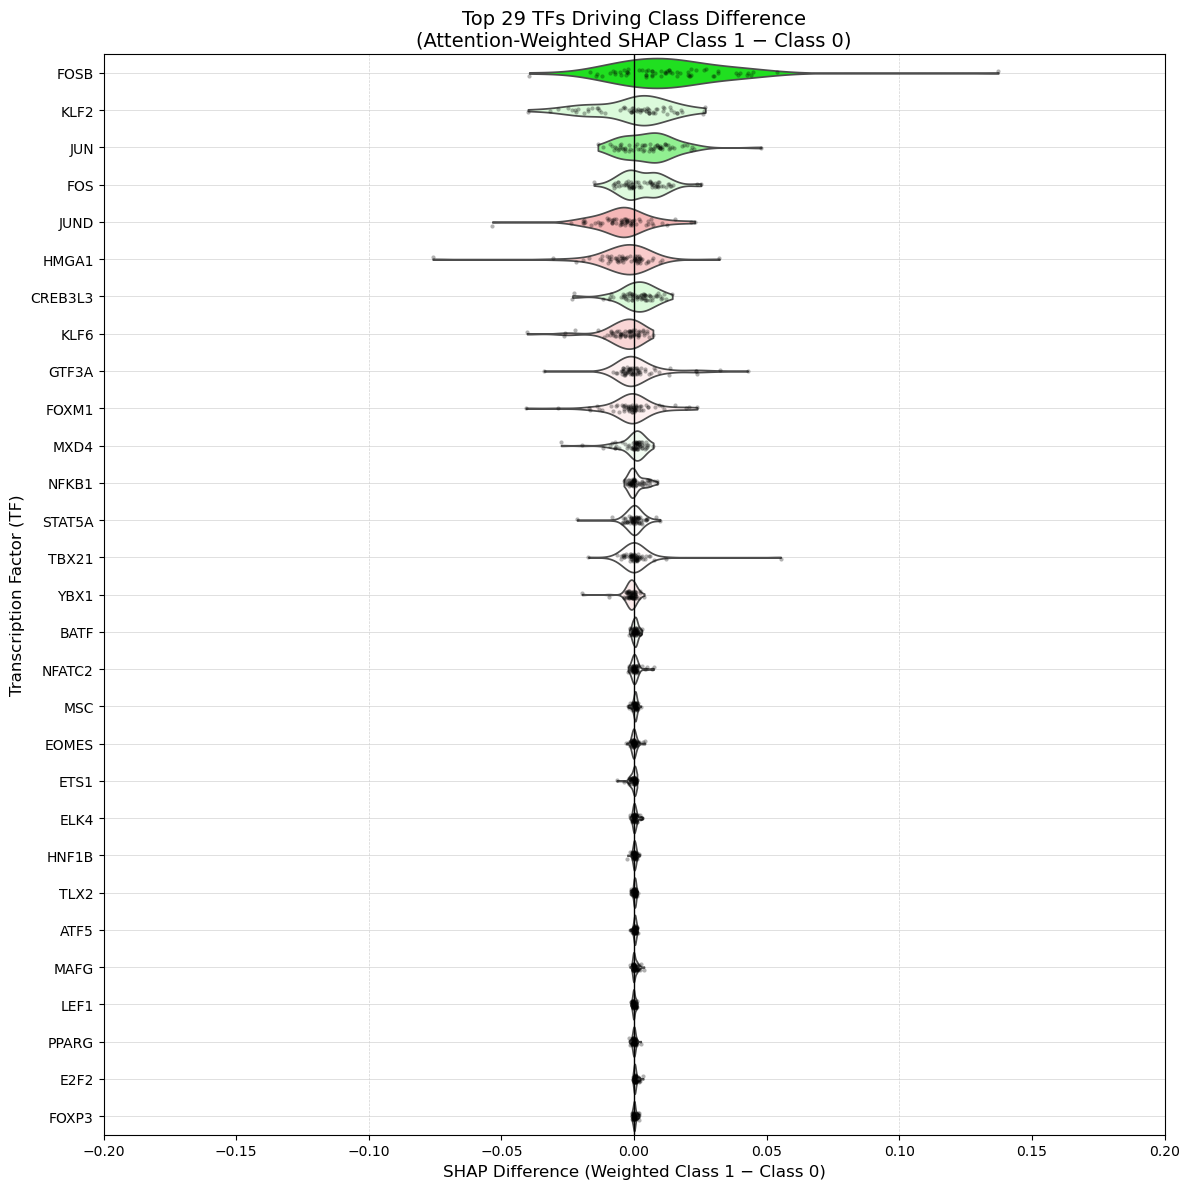

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Step 1: Compute per-patient signed SHAP difference
shap_diff_per_patient = df_weighted_class1 - df_weighted_class0  # shape: (n_patients, n_TFs)
unweighted_diff_per_patient = df_unweighted_class1 - df_unweighted_class0

# Step 2: Rank TFs by absolute **mean** SHAP difference across patients
mean_abs_diff = shap_diff_per_patient.abs().median(axis=0)
median_diff = shap_diff_per_patient.median(axis=0)
top_n = 29
top_tfs = mean_abs_diff.sort_values(ascending=False).head(top_n).index.tolist()


# Step 3: Prepare melted dataframe for plotting
df_plot = shap_diff_per_patient[top_tfs]
df_long = df_plot.reset_index().melt(id_vars='index', var_name='TF', value_name='SHAP_diff')
df_long.rename(columns={'index': 'patient_id'}, inplace=True)

# Step 4: Sort TFs by absolute mean (again, for y-axis order)
tf_order = mean_abs_diff.loc[top_tfs].sort_values(ascending=False).index.tolist()

# Step 5: Compute median signed SHAP difference to determine direction
medians = df_plot.median()

# Normalize magnitude for color intensity
max_mag = medians.abs().max()
normalized_magnitudes = (medians.abs() / max_mag).clip(0, 1)  # Scale to [0, 1]

# Build color map: green (positive) or red (negative), with hue by magnitude
def get_color(tf):
    mag = normalized_magnitudes[tf]
    if medians[tf] > 0:
        return mcolors.to_hex((1 - mag, 1, 1 - mag))  # green hues
    else:
        return mcolors.to_hex((1, 1 - mag, 1 - mag))  # red hues

palette_dict = {tf: get_color(tf) for tf in tf_order}

# Step 6: Create violin plot
plt.figure(figsize=(12, 12))

# Background lines for each TF row
for y in range(len(tf_order)):
    plt.axhline(y=y, color='lightgray', linewidth=0.5, zorder=0)

# Vertical gridlines at ticks
for tick in [-0.2, -0.1, 0, 0.1, 0.2]:
    plt.axvline(tick, color='lightgray', linestyle='--', linewidth=0.5, zorder=0)

# Plot violins
sns.violinplot(
    data=df_long,
    y='TF',
    x='SHAP_diff',
    order=tf_order,
    scale='width',
    inner=None,
    palette=palette_dict,
    cut=0
)

# Overlay patient-level points
sns.stripplot(
    data=df_long,
    y='TF',
    x='SHAP_diff',
    order=tf_order,
    size=3,
    jitter=True,
    color='black',
    alpha=0.3,
    zorder=2
)

# Plot formatting
plt.axvline(0, color='black', linestyle='-', linewidth=1)
plt.title(f"Top {top_n} TFs Driving Class Difference\n(Attention-Weighted SHAP Class 1 − Class 0)", fontsize=14)
plt.xlabel("SHAP Difference (Weighted Class 1 − Class 0)", fontsize=12)
plt.ylabel("Transcription Factor (TF)", fontsize=12)
plt.xlim(-0.2, 0.2)
plt.tight_layout()
# plt.savefig('/Users/kameronr/Documents/personal/Good lab/tcellMIL/diff_attention_weight_shap_scores_violin_plot_all_patients6_median_sorted_v2.pdf', format='pdf')
plt.show()









In [31]:
df_plot


,FOSB,KLF2,JUN,FOS,JUND,HMGA1,CREB3L3,KLF6,GTF3A,FOXM1,...,ETS1,ELK4,HNF1B,TLX2,ATF5,MAFG,LEF1,PPARG,E2F2,FOXP3
01,0.026212,-0.000846,0.011892,0.006905,-0.006988,-0.004675,-0.001923,-0.003465,-0.000737,0.000151,...,0.000164,-0.000133,-0.000429,0.000187,0.000572,-0.000006,-0.000597,-0.000384,0.000375,-0.000017
02,0.005402,-0.017526,0.007676,0.006330,-0.023757,-0.030750,-0.023230,-0.007193,-0.003740,0.023773,...,-0.001602,0.000800,-0.000100,0.000186,-0.001638,0.001709,-0.000748,-0.001857,0.000563,0.001087
03,0.006796,0.012385,0.003766,-0.000745,-0.008254,0.000320,-0.000421,0.001414,-0.004110,-0.012021,...,0.000281,-0.000227,0.000066,0.000339,-0.000289,-0.000140,0.001200,0.000286,-0.000343,-0.000462
04,0.020440,-0.017454,-0.005304,-0.003478,-0.004432,-0.004655,0.005688,-0.026254,0.003946,-0.013275,...,-0.000996,0.002316,0.001724,0.000556,0.001196,0.000869,0.000684,-0.000086,0.001813,0.001443
05,0.013214,0.008614,0.022659,0.012129,0.007003,-0.000209,0.007115,-0.000845,-0.002454,-0.008646,...,0.000370,-0.000374,0.000754,0.000079,0.000384,-0.000107,-0.000167,-0.000171,-0.000161,-0.000024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ac33,0.020316,0.016043,0.008735,0.008695,-0.004486,-0.010222,0.008417,-0.008119,-0.000028,0.000151,...,0.000231,-0.000039,-0.000023,0.000412,0.000483,-0.000220,-0.000132,0.000266,0.000318,0.000121
ac34,0.010156,0.004477,0.001233,-0.001823,-0.002770,-0.003391,0.012145,-0.006904,0.001928,-0.000916,...,0.000522,-0.000408,0.000469,0.000891,0.000286,-0.000366,-0.000447,0.000406,-0.000022,0.000104
ac37,0.023224,0.000566,0.015004,0.013961,-0.001607,-0.007126,-0.003839,-0.008427,-0.003800,0.001919,...,0.000601,-0.000368,0.000174,0.000903,0.000505,-0.000277,-0.000620,-0.000608,0.000303,0.000114
ac38,0.044791,0.004829,0.002868,-0.004952,-0.019369,-0.019400,0.004221,-0.011417,0.001001,0.015594,...,-0.001018,0.000604,-0.000145,0.000558,0.000899,-0.000445,-0.001348,0.000860,0.003442,0.000431


In [ ]:
import matplotlib.pyplot as plt

plot_df = grouped.reset_index().merge(attention_corr_df, on="TF")
plot_df["log_p"] = -np.log10(plot_df["p_adj"] + 1e-10)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    x=plot_df["correlation"],
    y=plot_df["shap_diff"],
    # c=plot_df["log_p"],
    cmap="Reds",
    edgecolor='k',
    s=50
)

# Add text labels to all data points
for idx, row in plot_df.iterrows():
    plt.text(row["correlation"] + 0.002, row["shap_diff"] + 0.00001, row["TF"], fontsize=6)

# Optional: highlight TFs with larger font
for _, row in plot_df.nlargest(5, "log_p").iterrows():
    plt.text(row["correlation"] + 0.005, row["shap_diff"], row["TF"], fontsize=8, fontweight='bold')

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Correlation of Cell Attention and Regulon Activity\n(mean Kendall Tau)")
plt.ylabel("Regulon SHAP Difference (OR vs. NR)")
plt.colorbar(scatter, label="-log₁₀(adj. p)")
plt.title("SHAP-based and Attention-based TF Importance")
plt.tight_layout()
plt.show()


In [ ]:

# ---- Weighted SHAP values ----

# Save signed SHAP differences (weighted)
shap_diff_per_patient.to_csv("/Users/kameronr/Documents/personal/Good lab/tcellMIL/signed_shap_differences_all_TFs.csv", index=True)

# Save original SHAP values (wide format)
df_weighted_class1.to_csv("/Users/kameronr/Documents/personal/Good lab/tcellMIL/shap_values_class1.csv", index=True)
df_weighted_class0.to_csv("/Users/kameronr/Documents/personal/Good lab/tcellMIL/shap_values_class0.csv", index=True)

# Convert to long format
df_class1_long = df_weighted_class1.reset_index().melt(id_vars='index', var_name='TF', value_name='SHAP')
df_class1_long['class'] = 'class1'
df_class0_long = df_weighted_class0.reset_index().melt(id_vars='index', var_name='TF', value_name='SHAP')
df_class0_long['class'] = 'class0'

# Combine both classes
df_all_shap = pd.concat([df_class1_long, df_class0_long])
df_all_shap.rename(columns={'index': 'patient_id'}, inplace=True)

# Save to CSV
df_all_shap.to_csv("/Users/kameronr/Documents/personal/Good lab/tcellMIL/shap_values_all_patients_long_v2.csv", index=False)

# ---- Unweighted SHAP values ----

# Save signed SHAP differences (unweighted)
unweighted_diff_per_patient.to_csv("/Users/kameronr/Documents/personal/Good lab/tcellMIL/signed_unweighted_shap_differences_all_TFs.csv", index=True)

# Save original SHAP values (wide format)
df_unweighted_class1.to_csv("/Users/kameronr/Documents/personal/Good lab/tcellMIL/unweighted_shap_values_class1.csv", index=True)
df_unweighted_class0.to_csv("/Users/kameronr/Documents/personal/Good lab/tcellMIL/unweighted_shap_values_class0.csv", index=True)

# Convert to long format
df_unweighted_class1_long = df_unweighted_class1.reset_index().melt(id_vars='index', var_name='TF', value_name='SHAP')
df_unweighted_class1_long['class'] = 'class1'
df_unweighted_class0_long = df_unweighted_class0.reset_index().melt(id_vars='index', var_name='TF', value_name='SHAP')
df_unweighted_class0_long['class'] = 'class0'

# Combine both classes
df_all_unweighted_shap = pd.concat([df_unweighted_class1_long, df_unweighted_class0_long])
df_all_unweighted_shap.rename(columns={'index': 'patient_id'}, inplace=True)

# Save to CSV
# df_all_unweighted_shap.to_csv("/Users/kameronr/Documents/personal/Good lab/tcellMIL/unweighted_shap_values_all_patients_long_v2.csv", index=False)